# Similarity Search Study

* [Powering Semantic Similarity Search in Computer Vision with State of the Art Embeddings](https://zilliz.com/learn/embedding-generation)

In [3]:
!pip list config

Package                   Version
------------------------- ---------
absl-py                   1.4.0
aiohttp                   3.8.5
aiosignal                 1.3.1
anyio                     3.7.1
appdirs                   1.4.4
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
arrow                     1.2.3
asttokens                 2.2.1
async-lru                 2.0.4
async-timeout             4.0.3
attrs                     23.1.0
Babel                     2.12.1
backcall                  0.2.0
beautifulsoup4            4.12.2
bleach                    6.0.0
blis                      0.7.10
cachetools                5.3.1
catalogue                 2.0.9
certifi                   2023.7.22
cffi                      1.15.1
charset-normalizer        3.2.0
click                     8.1.7
cloudpickle               2.2.1
colorama                  0.4.6
comm                      0.1.4
confection                0.1.1
contourpy                 1.1.0
cycler                 


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install towhee==0.5.0 lightning-bolts wandb gym opencv-python sentence_transformers spacy ftfy

In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np

from PIL import Image
from random import randint
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

tqdm.pandas()

D:\workspace\vector-database-algorithm\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\workspace\vector-database-algorithm\venv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
D:\workspace\vector-database-algorithm\venv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
def move_to_root_folder(root_path: str, cur_path: str):
    # Code from https://stackoverflow.com/questions/8428954/move-child-folder-contents-to-parent-folder-in-python
    for filename in os.listdir(cur_path):
        if os.path.isfile(os.path.join(cur_path, filename)):
            shutil.move(os.path.join(cur_path, filename), os.path.join(root_path, filename))
        elif os.path.isdir(os.path.join(cur_path, filename)):
            move_to_root_folder(root_path, os.path.join(cur_path, filename))
        else:
            sys.exit("Should never reach here.")

    # remove empty folders
    if cur_path != root_path:
        os.rmdir(cur_path)

move_to_root_folder(root_path='../data/cv/fashion', cur_path='../data/cv/fashion')

In [2]:
# Path to all the downloaded images
img_path = '../data/cv/fashion'

# Find list of all files in the path
images = [
    f'../data/cv/fashion/{f}' 
    for f in os.listdir(img_path) 
    if os.path.isfile(os.path.join(img_path, f))
]

# Load the file names to a dataframe
image_df = pd.DataFrame(images, columns=['img_path'])
print(image_df.shape)
image_df.head()

(6239, 1)


,img_path
0,../data/cv/fashion/1000000151.jpg
1,../data/cv/fashion/1000000170.jpg
2,../data/cv/fashion/1000001050.jpg
3,../data/cv/fashion/1000001113.jpg
4,../data/cv/fashion/1000001117.jpg


In [8]:
from towhee import pipeline

embedding_pipeline = pipeline("image-embedding")

In [9]:
image_df['embedding'] = image_df['img_path'].progress_apply(lambda x: np.squeeze(embedding_pipeline(x)))
image_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 6239/6239 [18:01<00:00,  5.77it/s]


,img_path,embedding
0,../data/cv/fashion/1000000151.jpg,"[0.0, 0.13571438, 0.07747779, 0.0, 0.06867723,..."
1,../data/cv/fashion/1000000170.jpg,"[0.020778598, 0.09365222, 0.10665407, 0.051480..."
2,../data/cv/fashion/1000001050.jpg,"[0.0, 0.017002566, 0.0101805935, 0.00038356014..."
3,../data/cv/fashion/1000001113.jpg,"[0.0, 0.032862574, 0.0, 0.0, 0.16102254, 0.0, ..."
4,../data/cv/fashion/1000001117.jpg,"[0.07896162, 0.0087613, 0.06798893, 0.0, 0.055..."


In [10]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6239 entries, 0 to 6238
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   6239 non-null   object
 1   embedding  6239 non-null   object
dtypes: object(2)
memory usage: 97.6+ KB


In [11]:
def plot_similar(df: pd.DataFrame, embedding_col: str, query_index: int, k_neighbors=5):
    """
    Helper function to take a dataframe index as input query 
    and display the k nearest neighbors
    """
    # Calculate pairwise cosine similarities between query and all rows
    similarities = cosine_similarity([df[embedding_col][query_index]],
                                     df[embedding_col].values.tolist())[0]
    # Find nearest neighbor indices
    k = k_neighbors + 1
    nearest_indices = np.argpartition(similarities, -k)[-k:]
    # Exclude the actual query_index from search
    nearest_indices = nearest_indices[nearest_indices != query_index]

    # Plot input image
    with Image.open(df["img_path"][query_index]) as img:
        img = img.convert("RGB")
        plt.imshow(img)
    plt.title("Query Product")

    # Plot nearest neighbors images
    fig = plt.figure(figsize=(20, 4))
    plt.suptitle("Similar Products")
    for idx, neighbor in enumerate(nearest_indices):
        plt.subplot(1, len(nearest_indices), idx+1)
        with Image.open(df["img_path"][neighbor]) as img:
            img = img.convert("RGB")
            plt.imshow(img)
            plt.title(f"Cosine Similarity: {similarities[neighbor]:.3f}")
    plt.tight_layout()


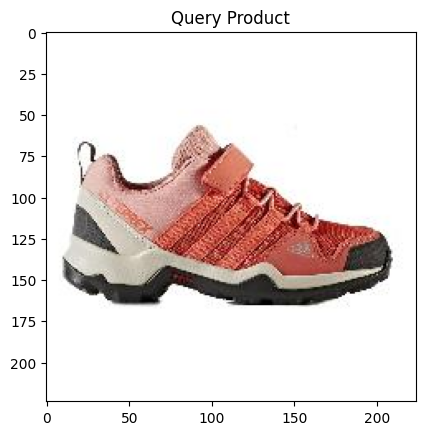

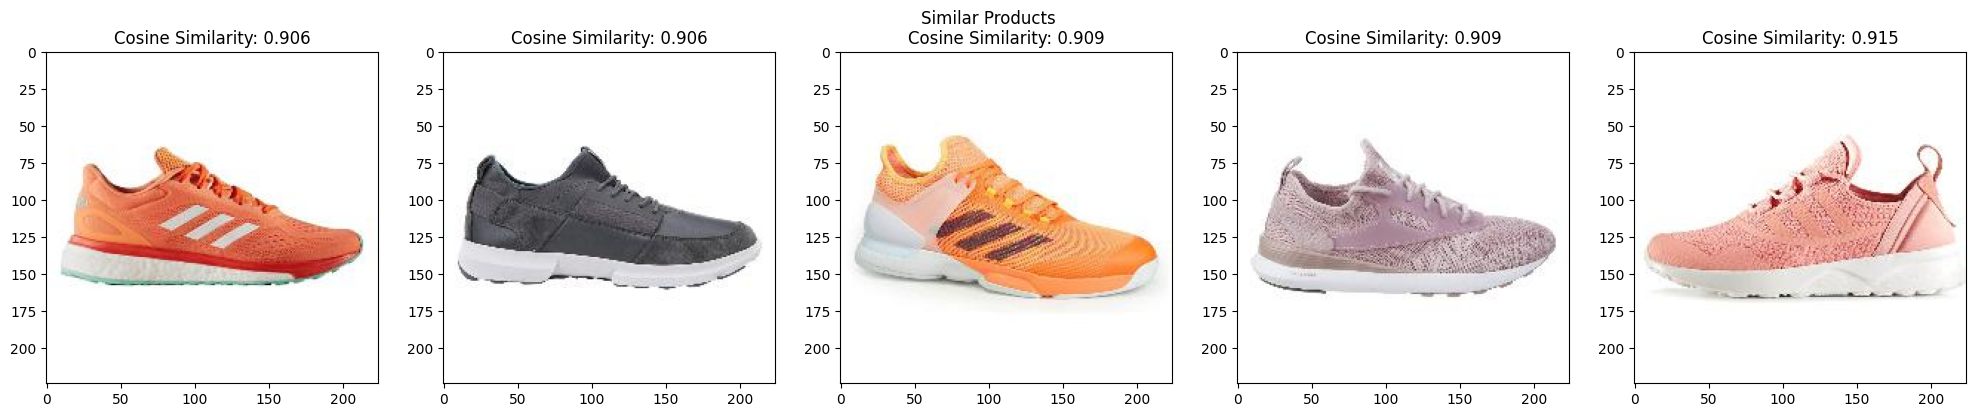

In [12]:
plot_similar(df=image_df,
             embedding_col='embedding',
             query_index=randint(0, len(image_df)),
             k_neighbors=5)

In [3]:
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
from pl_bolts.models.self_supervised import SimCLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

D:\workspace\vector-database-algorithm\venv\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
D:\workspace\vector-database-algorithm\venv\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
D:\workspace\vector-database-algorithm\venv\lib\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
D:\workspace\vector-database-algorithm\venv\lib\site-packages

In [14]:
# load resnet50 pre-trained using SimCLR on imagenet
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
simclr = SimCLR.load_from_checkpoint(weight_path, strict=False, batch_size=32)

# Send the SimCLR encoder to the device and set it to eval
simclr_resnet50 = simclr.encoder.to(device)
simclr_resnet50.eval()

2023-08-18 20:51:57,554 - 3292 - utils.py-utils:126 - INFO: Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file notebooks\https:\pl-bolts-weights.s3.us-east-2.amazonaws.com\simclr\bolts_simclr_imagenet\simclr_imagenet.ckpt`
venv\lib\site-packages\pytorch_lightning\core\saving.py:234: UnderReviewWarning: The feature SimCLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  obj = cls(**_cls_kwargs)
venv\lib\site-packages\pl_bolts\models\self_supervised\simclr\simclr_module.py:138: UnderReviewWarning: The feature resnet50 is currently marked under review. The compatibility with other Lightning projects is not guarante

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
class FashionImageDataset(Dataset):
    def __init__(self, image_df: pd.DataFrame, transform=None):
        self.image_df = image_df
        self.transform = transform

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_df.loc[idx, "img_path"]
        image = io.read_image(img_path, mode=io.image.ImageReadMode.RGB)/255

        # Apply Transformations
        if self.transform:
            image = self.transform(image)

        return image

In [16]:
# Transforms
## Normalize transform to ensure the images have similar intensity distributions as ImageNet
## Resize transform to ensure all images in a batch have the same size 

transformations = transforms.Compose([
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize(size=(64, 64))
])

# Create the DataLoader to load images in batches
emb_dataset = FashionImageDataset(image_df=image_df, transform=transformations)
emb_dataloader = DataLoader(emb_dataset, batch_size=32)

In [17]:
# Create embeddings
embeddings = []
for batch in tqdm(emb_dataloader):
    batch = batch.to(device)
    embeddings += simclr_resnet50(batch)[0].tolist()

# Assign embeddings to a column in the dataframe
image_df["simclr_embeddings"] = embeddings
image_df.head(2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [01:11<00:00,  2.73it/s]


,img_path,embedding,simclr_embeddings
0,../data/cv/fashion/1000000151.jpg,"[0.0, 0.13571438, 0.07747779, 0.0, 0.06867723,...","[0.0, 0.0, 0.0, 0.016052447259426117, 0.067167..."
1,../data/cv/fashion/1000000170.jpg,"[0.020778598, 0.09365222, 0.10665407, 0.051480...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


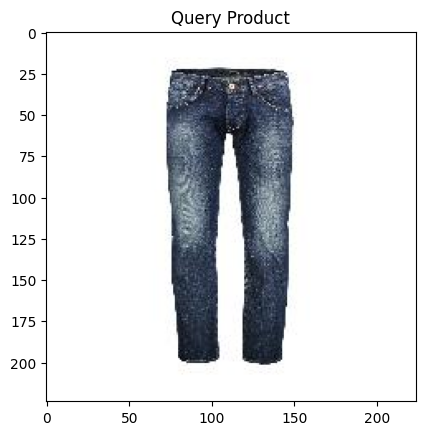

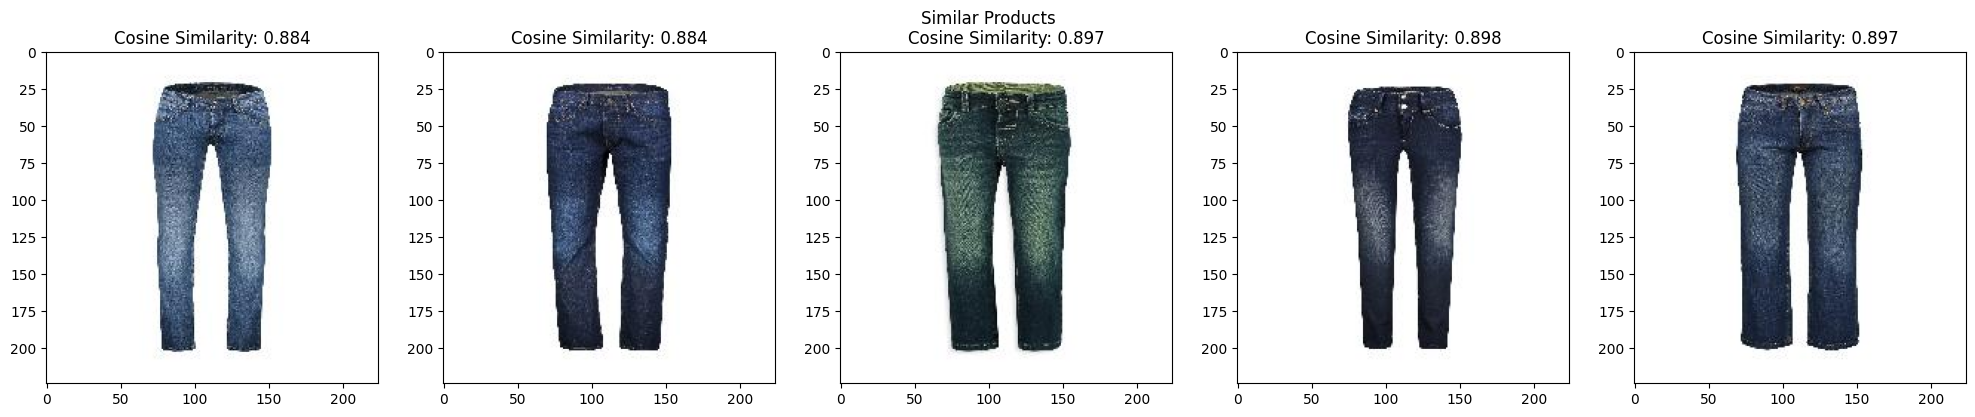

In [18]:
plot_similar(df=image_df,
             embedding_col='simclr_embeddings', 
             query_index=randint(0, len(image_df)), 
             k_neighbors=5)

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("clip-ViT-B-32")

In [20]:
# Initialize an empty list to collect embeddings
clip_embeddings = []

# Generate embeddings for 10_000 images on each iteration
step = 10_000

for idx in range(0, len(image_df), step):
    # Load the `step` number of images
    images = []
    images_to_close = []
    for img_path in image_df["img_path"].iloc[idx:idx+step]:
        img = Image.open(img_path)
        images.append(img.convert("RGB"))
        images_to_close.append(img)

    # Generate CLIP embeddings for the loaded images
    clip_embeddings.extend(model.encode(images, show_progress_bar=True).tolist())
    for to_close in images_to_close:
        to_close.close()

image_df["clip_image_embedding"] = clip_embeddings
image_df.head()

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

,img_path,embedding,simclr_embeddings,clip_image_embedding
0,../data/cv/fashion/1000000151.jpg,"[0.0, 0.13571438, 0.07747779, 0.0, 0.06867723,...","[0.0, 0.0, 0.0, 0.016052447259426117, 0.067167...","[-0.08758709579706192, -0.3124939203262329, 0...."
1,../data/cv/fashion/1000000170.jpg,"[0.020778598, 0.09365222, 0.10665407, 0.051480...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03924274817109108, -0.040139153599739075, ..."
2,../data/cv/fashion/1000001050.jpg,"[0.0, 0.017002566, 0.0101805935, 0.00038356014...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07215095311403275, -0.07616670429706573, 0..."
3,../data/cv/fashion/1000001113.jpg,"[0.0, 0.032862574, 0.0, 0.0, 0.16102254, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.10626209527254105, 0.0,...","[0.12239596992731094, 0.23508524894714355, 0.2..."
4,../data/cv/fashion/1000001117.jpg,"[0.07896162, 0.0087613, 0.06798893, 0.0, 0.055...","[0.0, 0.0, 0.0, 0.0, 0.014906682074069977, 0.0...","[0.24037981033325195, 0.0034865587949752808, 0..."


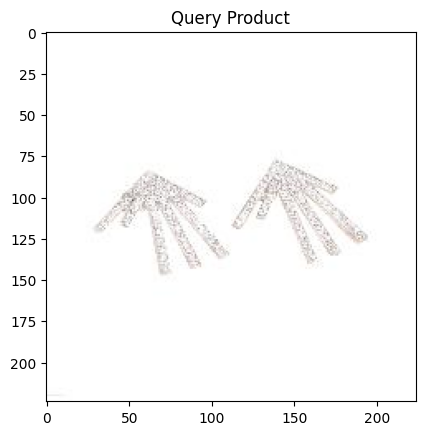

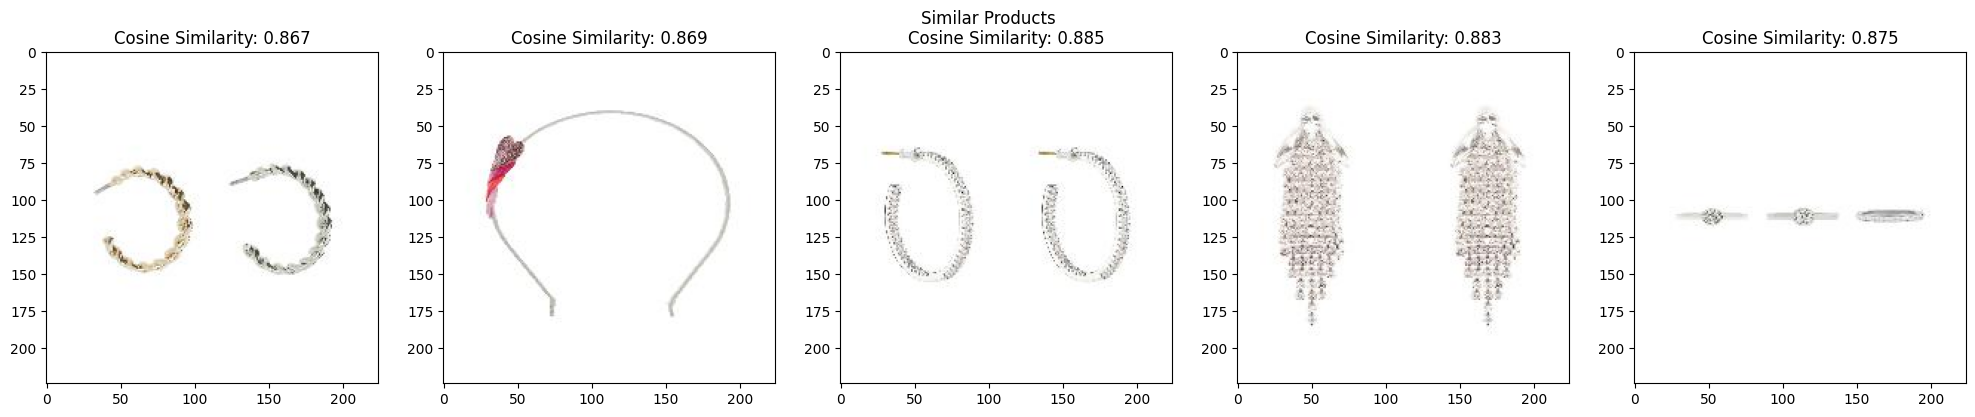

In [25]:
plot_similar(df=image_df,
             embedding_col="clip_image_embedding",
             query_index=randint(0, len(image_df)),
             k_neighbors=5)

In [30]:
def text_image_search(df: pd.DataFrame, text_query: str, img_emb_col: str, k=5):
    """
    Helper function to take a text query as input and display the k nearest neighbor images
    """

    # Calculate the text embeddings
    text_emb = model.encode(text_query).tolist()

    # Calculate the pairwise cosine similarities between text query and images from all rows
    similarities = cosine_similarity([text_emb], df[img_emb_col].values.tolist())[0]

    # Find nearest neighbors
    nearest_indices = np.argpartition(similarities, -k)[-k:]

    # Print query text
    print(f"Query text: {text_query}")

    # Plot nearest neighbors images
    fig = plt.figure(figsize=(20, 4))
    plt.suptitle("Similar Products")
    for idx, neighbor in enumerate(nearest_indices):
        plt.subplot(1, len(nearest_indices), idx+1)
        with Image.open(df["img_path"][neighbor]) as img:
            img = img.convert("RGB")
            plt.imshow(img)
            plt.title(f"Cosine Sim: {similarities[neighbor]:.3f}")
    plt.tight_layout()

Query text: a photo of a women's dress


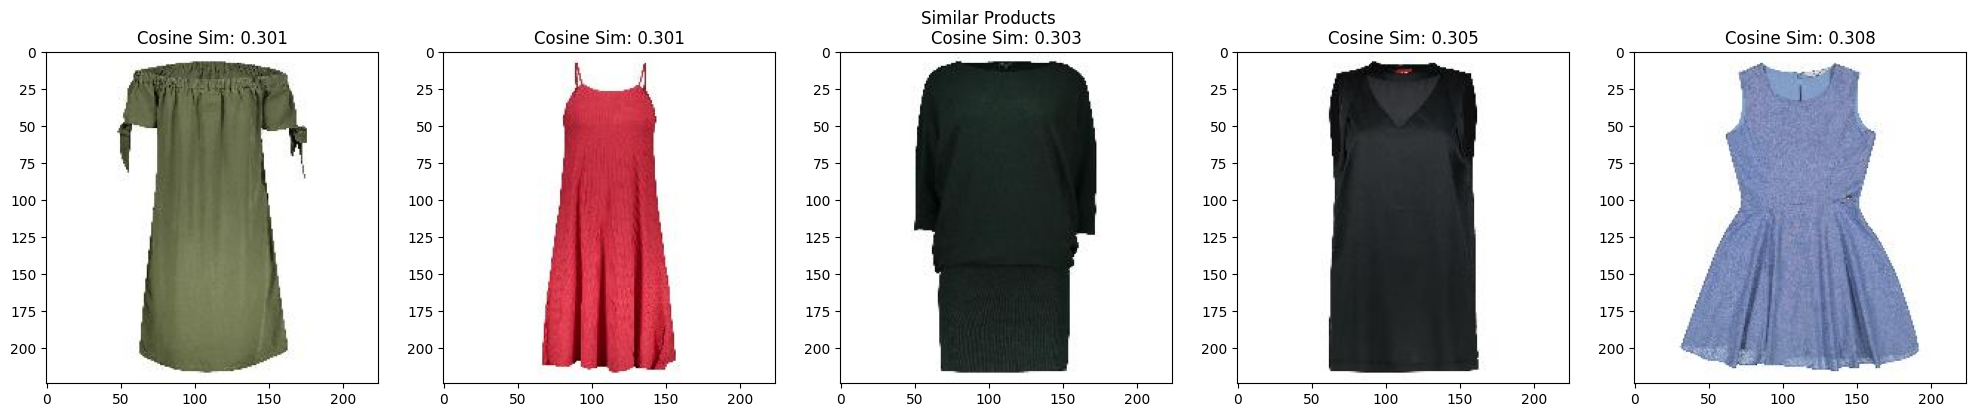

In [32]:
text_query = "a photo of a women's dress"
text_image_search(df=image_df, 
                  text_query=text_query,
                  img_emb_col='clip_image_embedding', 
                  k=5)

In [33]:
image_df.to_pickle("image_df.pkl")

In [36]:
import os

if os.path.exists("image_df.pkl"):
    image_df = pd.read_pickle("image_df.pkl")